# Causal Inference with Quasi (Natural) Experiments

Thus far, we have examined methods that are typically associated with estimating the average treatment effect for experimental data. With experimental data, randomness is introduced via treatment assignment. In constrast, with a natural experiment (quasi-experimental data), randomness is introduced via some factors that make it appear as if the treatment were randomly assigned.


## Regression Discontinuity

One common way that this type of randomness is introduced is when treatment is only applied when some observable covariate crosses a threshold. For example, a patient in a hospital may receive a certain medication only when their blood pressure drops below some critical threshold. The **Regression Discontinuity** estimator leverages the variation induced at this boundary in order estimate an average effect of the treatment. The general idea is that individuals very close to the cutoff value are likely to be very similar, so there is a natural matching between the treatment group (those just above the threshold) and the control group (those just below the threshold).

Considering our class size example again, let's assume that small class sizes are no longer randomly assigned, but rather, arise naturally because of a school policy that any classroom with more than 23 students must be split in half. Students are randomly assigned classrooms, so those are ultimately sub-divided are random. Any jump in test scores for classrooms that are split relative to those that just missed the split can reasonably be attributed to the effect of the smaller class size. We can estimate the size of this discontinuity using standard OLS with an indicator variable at the threshold. Because all classrooms below the threshold are not split and all above the theshold are split, this is referred to as a **sharp regression discontinuity** design.

### Sharp Regression Discontinuity

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.linalg import cholesky
from sklearn.preprocessing import minmax_scale, scale

%matplotlib inline

In [2]:
population_size = 5000
threshold = 24
possible_class_sizes = np.arange(16, 31, 1)
original_class_sizes = np.random.choice(possible_class_sizes, population_size)\

# Simulate split classrooms
actual_class_sizes = np.array([int(round(n / 2)) if n >= threshold else n for n in original_class_sizes])
split_class = np.array([1 if n >= threshold else 0 for n in original_class_sizes])

treatment_effect = 10
population_scores = 75 + treatment_effect*split_class + np.random.normal(loc=0.0, scale=5.0, size=population_size)

# Plot the distribution
treatment_df = pd.DataFrame()
treatment_df["orig_class_size"] = original_class_sizes
treatment_df["actual_class_size"] = actual_class_sizes
treatment_df["split_class"] = treatment_df["orig_class_size"] >= threshold
treatment_df["pop_reg_line"] = 75 + treatment_effect*treatment_df["split_class"]
treatment_df["score"] = population_scores

treatment_df.head()

,orig_class_size,actual_class_size,split_class,pop_reg_line,score
0,18,18,False,75,77.525715
1,20,20,False,75,72.858189
2,27,14,True,85,75.055506
3,18,18,False,75,74.636705
4,17,17,False,75,72.295689


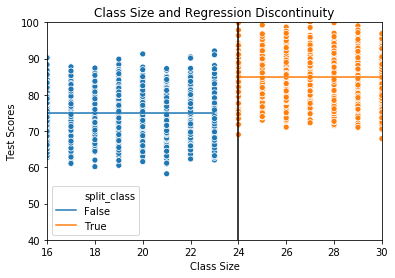

In [3]:
fig, ax = plt.subplots()
sns.lineplot(x="orig_class_size", 
             y="pop_reg_line", 
             hue="split_class", 
             data=treatment_df, 
             ax=ax)
sns.scatterplot(x="orig_class_size", 
                y="score", 
                hue="split_class", 
                data=treatment_df, 
                estimator=None, 
                ax=ax, 
                legend=False)

ax.axvline(threshold, 0, 1, color="black")
ax.set_xlim(16, 30)
ax.set_ylim(40, 100)
ax.set_xlabel("Class Size")
ax.set_ylabel("Test Scores")
ax.set_title("Class Size and Regression Discontinuity")
plt.savefig("./images/sharp_rd_class_size.png", dpi=300)

In [4]:
model = smf.ols(formula="score ~ 1 + split_class", data=treatment_df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     4907.
Date:                Sun, 30 Jun 2019   Prob (F-statistic):               0.00
Time:                        20:59:39   Log-Likelihood:                -15151.
No. Observations:                5000   AIC:                         3.031e+04
Df Residuals:                    4998   BIC:                         3.032e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              74.9410      0.098    765.378      0.000      74.749      75.133
split_class[T.True]     9.9368      0.142     70.047      0.000       9.659      10.215
==============================================================================
Omnibus:                        1.219   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.544   Jarque-Bera (JB):                1.244
Skew:                           0.016   Prob(JB):                        0.537
Kurtosis:                       2.930   Cond. No.                         2.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Including a dummy variable (split class) that captures the discontinuity of interest allows standard OLS to be able to recover the simulated ATE of 10 points. Although the current example was constructed such that any split classroom resulted in a 10 point bump in test scores, the same process could be used if the treatment effect was directly proportional to the size of the class. Can you modify the code above to simulate a treatment effect where each additional student causes average test scores to fall by 0.5? What parts of the code would need to change? What is the new estimated ATE?

### Fuzzy Regression Discontinuity

Now, let's consider the situation where the threshold of interest merely increases the probability of receiving treatment. This is referred to as a  **fuzzy regression discontinuity** design. To get an unibased estimate of the ATE, we use the threshold as a instrumental variable for the actual treatment received. Think back to the previous notebook. Does this proposed instrument satisify the two criteria for a valid instrument (relevance and exogeneity)?

Since crossing the threshold increases the probability of receiviung treatment, the endogeneous variable (treatment) and the proposed instrument are clearly correlated. Secondly, if the only effect of crossing the treshold is to increase the probability of receiving treatment (no other unobserved or observed covariates are affected), then the exogeneity requirement is also satisfied.

We will use the same hypothetical scenario as before. Now, instead of crossing the threshold guaranteeing that the class will be split, the classroom will only become a candidate for splitting. Since there are a limited number of teachers available, all classes that would ideally be split cannot be, so classes are chosen partially at random to be split.

In [5]:
sample_size = 5000

corr_mat = np.array([
    [1.0, 0.8],
    [0.8, 1.0]
])

upper_cholesky = cholesky(corr_mat)
random_data = np.random.normal(0, 1, size=(sample_size, 2))
transformed_data = random_data @ upper_cholesky

candidate_split_class = minmax_scale(transformed_data[:, 0], feature_range=(0,1))
candidate_split_class = [1 if s > 0.5 else 0 for s in candidate_split_class]

split_class = minmax_scale(transformed_data[:, 1] ,feature_range=(0,1))
split_class = np.array([1 if s > np.median(split_class) else 0 for s in split_class])

treatment_effect = 10
sample_scores = 75 + treatment_effect*split_class + np.random.normal(loc=0.0, scale=5.0, size=population_size)

# Plot the distribution
treatment_df = pd.DataFrame()
treatment_df["oversized_class"] = candidate_split_class
treatment_df["split_class"] = split_class
treatment_df["score"] = sample_scores

treatment_df.head()

,oversized_class,split_class,score
0,0,0,84.234445
1,1,1,87.402308
2,0,0,71.614019
3,1,1,90.358795
4,0,0,77.541405


In [6]:
# Naive Regression
model = smf.ols(formula="score ~ 1 + split_class", data=treatment_df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     5125.
Date:                Sun, 30 Jun 2019   Prob (F-statistic):               0.00
Time:                        20:59:41   Log-Likelihood:                -15087.
No. Observations:                5000   AIC:                         3.018e+04
Df Residuals:                    4998   BIC:                         3.019e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      74.9539      0.099    757.635      0.000      74.760      75.148
split_class    10.0160      0.140     71.589      0.000       9.742      10.290
==============================================================================
Omnibus:                        0.810   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.667   Jarque-Bera (JB):                0.773
Skew:                          -0.028   Prob(JB):                        0.680
Kurtosis:                       3.023   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
first_stage_model = smf.ols(formula="split_class ~ 1 + oversized_class", data=treatment_df)
first_stage_result = first_stage_model.fit()
first_stage_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            split_class   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     2538.
Date:                Sun, 30 Jun 2019   Prob (F-statistic):               0.00
Time:                        20:59:43   Log-Likelihood:                -2602.3
No. Observations:                5000   AIC:                             5209.
Df Residuals:                    4998   BIC:                             5222.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2194      0.008     27.387      0.000       0.204       0.235
oversized_class     0.5807      0.012     50.378      0.000       0.558       0.603
==============================================================================
Omnibus:                        2.176   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.337   Jarque-Bera (JB):                2.133
Skew:                           0.049   Prob(JB):                        0.344
Kurtosis:                       3.028   Cond. No.                         2.58
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Oversized classes appear to be a good instrument for treatment since they explain a fair amount of the variation in treatment and the F-statistic from the first stage is well above the folk-lore threshold of 10.

In [8]:
predicted_values = first_stage_result.predict(treatment_df)
treatment_df["predicted_treatment"] = predicted_values

second_stage_model = smf.ols(formula="score ~ 1 + predicted_treatment", data=treatment_df)
second_stage_result = second_stage_model.fit()
second_stage_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     1001.
Date:                Sun, 30 Jun 2019   Prob (F-statistic):          1.99e-200
Time:                        20:59:45   Log-Likelihood:                -16395.
No. Observations:                5000   AIC:                         3.279e+04
Df Residuals:                    4998   BIC:                         3.281e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              75.0075      0.181    414.303      0.000      74.653      75.362
predicted_treatment     9.9088      0.313     31.640      0.000       9.295      10.523
==============================================================================
Omnibus:                        0.505   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.777   Jarque-Bera (JB):                0.467
Skew:                          -0.020   Prob(JB):                        0.792
Kurtosis:                       3.025   Cond. No.                         4.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Differences in Differences